#### Author: Aditya Jain
#### Topic : TD(n) and Mountain Car

In [1]:
import matplotlib.pyplot as plt
import gym
from IPython import display as ipythondisplay
import numpy as np
import json
import pickle

#### Exercise 1: Prelims
Here we explore the mountain car environment

In [8]:
env = gym.make('MountainCar-v0')

print('Observation Space: ', env.observation_space)
print('Action Space: ', env.action_space)

Observation Space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space:  Discrete(3)


The environment's state space is represented by two variables: car position and car velocity. The car position can vary from -1.2 to 0.6 and velocity varies from -0.07 to 0.07.
The agent can choose to take 3 actions: accelerate left (0), accelerate right (2) or don't accelerate (1). The environment's model is not available, hence, we cannot use DP.

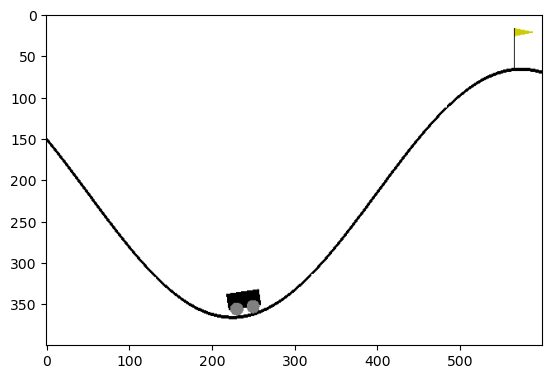

In [9]:
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for _ in range(10):
    env.step(env.action_space.sample()) # take a random action
    screen = env.render(mode='rgb_array')  
    plt.imshow(screen)
    
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
env.close()

#### Check Controller Performance
The below function is used to check the RL controller over n (=1000) trials

In [2]:
def control_performance(env_name, pos_fac, vel_fac, policy, no_actions, trials):
    
    env          = gym.make(env_name)
    reward_list  = []
    steps_list   = []
    reached_goal = 0
    
    for i in range(trials):
        done           = False
        episode_reward = 0
        obs            = env.reset()
        obs            = process_state(obs, pos_fac, vel_fac)
        steps          = 0
        
        while not done:
            action                  = np.random.choice(no_actions, p=policy[obs])
            obs, reward, done, info = env.step(action)
            steps                   += 1
            episode_reward          += reward
            obs                     = process_state(obs, pos_fac, vel_fac)
            
        if steps<200:
            steps_list.append(steps)
            reached_goal += 1            
            
        reward_list.append(episode_reward)
        
    return reached_goal, steps_list

Defining some helper functions

In [3]:
def epsilon_greedy_action_policy(obs, epsilon, no_actions, policy): 
    '''chooses epsilon greedy action given a policy'''
    
    if np.random.rand()<epsilon:
        action = np.random.choice(no_actions, p=[1/no_actions, 1/no_actions, 1/no_actions]) 
    else:
        action = np.random.choice(no_actions, p=policy[obs]) 
    
    return action
    
    
def process_state(state, p_fac, v_fac):
    return (round(state[0]*p_fac), round(state[1]*v_fac))


def epsilon_greedy_action_Q(obs, epsilon, no_actions, Qpi_sa): 
    '''chooses epsilon greedy action given Q function'''
    
    if np.random.rand()<epsilon:  # random action 
        action = np.random.choice(no_actions, p=[1/no_actions, 1/no_actions, 1/no_actions]) 
    else:                         # greedy actions
        qpi_list = []        
        for action in range(no_actions):
            qpi_list.append(Qpi_sa[obs, action])
            
        maxa_list = np.argwhere(qpi_list == np.amax(qpi_list))
        maxa_list_indx = []
        
        # indices that have max. q values
        for item in maxa_list:
            maxa_list_indx.append(item[0])
            
        act_probab = [0, 0, 0]
        for i in range(no_actions):
            if i in maxa_list_indx:
                act_probab[i] = 1/len(maxa_list_indx)
            else:
                act_probab[i] = 0
        
        action = np.random.choice(no_actions, p=act_probab) 
    
    return action

def get_policy(state_list, Qpi_sa):
    ''''
    based on the Q function, returns the policy
    '''
    
    policy = {}    
    
    for state in state_list:
        qpi_list = []
        
        for action in range(no_actions):
            qpi_list.append(Qpi_sa[state, action])
        
        maxa_list      = np.argwhere(qpi_list == np.amax(qpi_list))
        maxa_list_indx = []
        
        # indices that have max. q values
        for item in maxa_list:
            maxa_list_indx.append(item[0])
            
        # updating the new policy policy
        policy[state] = [0, 0, 0]
        for i in range(no_actions):
            if i in maxa_list_indx:
                policy[state][i] = 1/len(maxa_list_indx)
            else:
                policy[state][i] = 0
                
    return policy

##### Random Policy

In [83]:
random_policy_pi = {}

for item in state_list:
    random_policy_pi[item] = [1/no_actions, 1/no_actions, 1/no_actions] # action is 0, 1 or 2
    
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, random_policy_pi, no_actions, 1000)
print('Success rate of random policy over 1000 runs: ', (success/1000)*100, '%')
if len(steps)!=0:    
    print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

Success rate of random policy over 1000 runs:  0.0 %


#### Task 1: TD(0) On-Policy SARSA
Intialization of an arbitrary state-action value function


In [22]:
Qpi_sa     = {}
state_list = [] # contains the list of states
no_actions = 3   # 0, 1 and 2

# multiplicative factor of 100
pos_min    = -120
pos_max    = 60
pos_inc    = 1
pos_fac    = 100

# multiplicative factor of 100
vel_min    = -7
vel_max    = 7
vel_inc    = 1
vel_fac    = 100

for pos in range(pos_min, pos_max+1, pos_inc):
    for vel in range(vel_min, vel_max+1, vel_inc):
        state_list.append((pos, vel))
        for action in range(no_actions):
            Qpi_sa[(pos, vel), action] = 0

Intialization of an arbitrary policy based on Qpi

In [23]:
policy_pi = {}

for key in Qpi_sa.keys():
    policy_pi[key[0]] = [1/no_actions, 1/no_actions, 1/no_actions] # action is 0, 1 or 2

In [17]:
env         = gym.make('MountainCar-v0')

episodes    = 0
epsilon     = 0.1
alpha       = 0.5
gamma       = 0.9
converged   = False

while not converged:
    episodes += 1
    
    cur_obs     = env.reset()
    cur_obs     = process_state(cur_obs, pos_fac, vel_fac)
    cur_action  = epsilon_greedy_action_policy(cur_obs, epsilon, no_actions, policy_pi)
    done        = False
    
    while not done:        
        next_obs, reward, done, info = env.step(cur_action)
        next_obs                     = process_state(next_obs, pos_fac, vel_fac)
        next_action                  = epsilon_greedy_action_policy(next_obs, epsilon, no_actions, policy_pi)
        Qpi_sa[cur_obs,cur_action]   = Qpi_sa[cur_obs,cur_action] + alpha*(reward + gamma*Qpi_sa[next_obs,next_action] - Qpi_sa[cur_obs,cur_action])
        cur_obs                      = next_obs
        cur_action                   = next_action
        
    new_policy  = get_policy(state_list, Qpi_sa)    
    if new_policy==policy_pi:
        converged = True
        
    policy_pi = new_policy

In [85]:
pickle.dump(policy_pi, open("task1_onpolicy-sarsa.p", "wb" ))
print('Episodes took to converge for on-policy SARSA: ', episodes)
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, policy_pi, no_actions, 1000)
print('Success rate of on-policy SARSA control over 1000 runs: ', (success/1000)*100, '%')
print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

Episodes took to converge for on-policy SARSA:  11413
Success rate of on-policy SARSA control over 1000 runs:  6.5 %
Average steps taken to reach the goal:  178.56923076923076


#### Task 1: TD(0) On-Policy Expected SARSA
Intialization of an arbitrary state-action value function

In [86]:
Qpi_sa     = {}
state_list = [] # contains the list of states
no_actions = 3   # 0, 1 and 2

# multiplicative factor of 100
pos_min    = -120
pos_max    = 60
pos_inc    = 1
pos_fac    = 100

# multiplicative factor of 100
vel_min    = -7
vel_max    = 7
vel_inc    = 1
vel_fac    = 100

for pos in range(pos_min, pos_max+1, pos_inc):
    for vel in range(vel_min, vel_max+1, vel_inc):
        state_list.append((pos, vel))
        for action in range(no_actions):
            Qpi_sa[(pos, vel), action] = 0

In [87]:
policy_pi = {}

for item in state_list:
    policy_pi[item] = [1/no_actions, 1/no_actions, 1/no_actions] # action is 0, 1 or 2

In [88]:
env         = gym.make('MountainCar-v0')

episodes    = 0
epsilon     = 0.1
alpha       = 0.5
gamma       = 0.9
converged   = False

while not converged:
    episodes += 1
    
    # Policy Evaluation
    cur_obs     = env.reset()
    cur_obs     = process_state(cur_obs, pos_fac, vel_fac)
    cur_action  = epsilon_greedy_action_policy(cur_obs, epsilon, no_actions, policy_pi)
    done        = False
    
    while not done:        
        next_obs, reward, done, info = env.step(cur_action)
        next_obs                     = process_state(next_obs, pos_fac, vel_fac)
        next_action                  = epsilon_greedy_action_policy(next_obs, epsilon, no_actions, policy_pi)
        expect_q_sum                 = 0
        for action in range(no_actions):
            expect_q_sum             += policy_pi[next_obs][action]* Qpi_sa[next_obs, action]
            
        Qpi_sa[cur_obs,cur_action]   = Qpi_sa[cur_obs,cur_action] + alpha*(reward + gamma*expect_q_sum - Qpi_sa[cur_obs,cur_action])
        cur_obs                      = next_obs
        cur_action                   = next_action
        
        
    # Policy Improvement
    new_policy_pi  = get_policy(state_list, Qpi_sa)                
    if new_policy_pi==policy_pi:
        converged = True
        
    policy_pi = new_policy_pi 
    
pickle.dump(policy_pi, open("task1_onpolicy-expectedsarsa.p", "wb" ))

In [90]:
print('Episodes took to converge for on-policy Expected SARSA: ', episodes)
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, policy_pi, no_actions, 1000)
print('Success rate of on-policy Expected SARSA control over 1000 runs: ', (success/1000)*100, '%')
print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

Episodes took to converge for on-policy Expected SARSA:  9518
Success rate of on-policy Expected SARSA control over 1000 runs:  7.3 %
Average steps taken to reach the goal:  171.32876712328766


#### Task 1: TD(0) Off-Policy Expected SARSA with a greedy control policy
Intialization of an arbitrary state-action value function

In [118]:
Qpi_sa     = {}
state_list = [] # contains the list of states
no_actions = 3   # 0, 1 and 2

# multiplicative factor of 100
pos_min    = -120
pos_max    = 60
pos_inc    = 1
pos_fac    = 100

# multiplicative factor of 100
vel_min    = -7
vel_max    = 7
vel_inc    = 1
vel_fac    = 100

for pos in range(pos_min, pos_max+1, pos_inc):
    for vel in range(vel_min, vel_max+1, vel_inc):
        state_list.append((pos, vel))
        for action in range(no_actions):
            Qpi_sa[(pos, vel), action] = 0

Initialization of behaviour (B) and target (Pi) policy

In [119]:
policy_pi = {}             # target policy

for item in state_list:
    policy_pi[item] = [1/no_actions, 1/no_actions, 1/no_actions] # action is 0, 1 or 2
    
policy_b  = policy_pi      # behaviour policy

In [120]:
def update_behaviour_policy(pol_pi, state_list, no_actions, epsilon):
    '''
    makes the behaviour policy exploratory with respect to policy pi
    '''
    pol_b = {}
    
    for state in state_list:
        nonzeroind   = np.nonzero(policy_pi[state])[0]
        pol_b[state] = [0,0,0]
        
        for action in range(no_actions):
            if action not in nonzeroind:
                pol_b[state][action] = epsilon/no_actions 
            else:
                pol_b[state][action] = policy_pi[state][action] - ((no_actions-len(nonzeroind))/len(nonzeroind))*(epsilon/no_actions)
                
    return pol_b



In [121]:
env         = gym.make('MountainCar-v0')

episodes    = 0
epsilon     = 0.1
alpha       = 0.5
gamma       = 0.9
converged   = False

while not converged:
    episodes += 1
    
    # Policy Evaluation
    cur_obs     = env.reset()
    cur_obs     = process_state(cur_obs, pos_fac, vel_fac)
    cur_action  = np.random.choice(no_actions, p=policy_b[cur_obs])     # action chosen from behaviour policy
    done        = False
    
    while not done:        
        next_obs, reward, done, info = env.step(cur_action)
        next_obs                     = process_state(next_obs, pos_fac, vel_fac)
        next_action                  = np.random.choice(no_actions, p=policy_b[next_obs])     # action chosen from behaviour policy
        expect_q_sum                 = 0
        for action in range(no_actions):
            expect_q_sum             += policy_pi[next_obs][action]* Qpi_sa[next_obs, action]
            
        Qpi_sa[cur_obs,cur_action]   = Qpi_sa[cur_obs,cur_action] + alpha*(reward + gamma*expect_q_sum - Qpi_sa[cur_obs,cur_action])
        cur_obs                      = next_obs
        cur_action                   = next_action
        
        
    # Policy Improvement
    new_policy_pi  = get_policy(state_list, Qpi_sa)                 
    if new_policy_pi==policy_pi:
        converged = True
        
    policy_pi = new_policy_pi 
    policy_b  = update_behaviour_policy(policy_pi, state_list, no_actions, epsilon)
    
pickle.dump(policy_pi, open("task1_offpolicy-expectedsarsa.p", "wb" ))

In [122]:
print('Episodes took to converge for off-policy Expected SARSA: ', episodes)
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, policy_pi, no_actions, 1000)
print('Success rate of off-policy Expected SARSA control over 1000 runs: ', (success/1000)*100, '%')
print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

Episodes took to converge for off-policy Expected SARSA:  9189
Success rate of off-policy Expected SARSA control over 1000 runs:  12.5 %
Average steps taken to reach the goal:  174.88


#### Task 1 Comparison

| Controller Type | Episodes Taken to Converge | Success Rate | Avg. Steps to Goal |
| --- | --- | --- | --- |
| On-policy SARSA | 11413 | 6.5 % | 178.57 | 
| On-policy Expected SARSA | 9518 | 7.3 % | 171.32 |
| Off-policy Expected SARSA | 9189 | 12.5 % | 174.88 |

It is evident that expected SARSA converges faster to the optimal policy as compared to SARSA. The expected versions also have better success rates. There is a significant performance difference between on-policy and off-policy expected SARSA. The off-policy version has ~71% additional success rate over on-policy. This can be attributed to sufficient exploration in off-policy expected SARSA.

#### Exercise 2: TD(n) - nstep SARSA control
Contains an implementation of control algorithms that use TD(n) SARSA. The implementation is tested in Task 2

In [4]:
def n_sarsa(epsilon, alpha, gamma, n_step): 
    
    Qpi_sa     = {}
    state_list = [] # contains the list of states
    no_actions = 3   # 0, 1 and 2

    # multiplicative factor of 100
    pos_min    = -120
    pos_max    = 60
    pos_inc    = 1
    pos_fac    = 100

    # multiplicative factor of 100
    vel_min    = -7
    vel_max    = 7
    vel_inc    = 1
    vel_fac    = 100

    for pos in range(pos_min, pos_max+1, pos_inc):
        for vel in range(vel_min, vel_max+1, vel_inc):
            state_list.append((pos, vel))
            for action in range(no_actions):
                Qpi_sa[(pos, vel), action] = 0
                
    policy_pi = {}
    for item in state_list:
        policy_pi[item] = [1/no_actions, 1/no_actions, 1/no_actions] # action is 0, 1 or 2
        
        
    env         = gym.make('MountainCar-v0')

    episodes    = 0
    converged   = False

    while not converged:
        episodes += 1
    
        ## Policy Evaluation ##
        cur_obs     = env.reset()
        cur_obs     = process_state(cur_obs, pos_fac, vel_fac)
        cur_action  = epsilon_greedy_action_policy(cur_obs, epsilon, no_actions, policy_pi)
        done        = False
        t           = 0
        t_term      = pow(10,8)              # the termination step
        trans_list  = []
        trans_list.append([cur_obs, cur_action])
    
        while not done:        
            next_obs, reward, done, info = env.step(cur_action)     
            if done:
                t_term = t+1
            next_obs                     = process_state(next_obs, pos_fac, vel_fac) 
            next_action                  = epsilon_greedy_action_policy(next_obs, epsilon, no_actions, policy_pi)
            cur_obs                      = next_obs
            cur_action                   = next_action
            trans_list.append([next_obs, next_action, reward])
        
            tau = t-n_step+1        
            if tau>=0:       
                G   = 0
                for i in range(tau+1, min((tau+n_step+1), t_term+1)):
                    G += pow(gamma, i-tau-1)*trans_list[i][2]
            
                if tau+n_step<t_term:
                    G += pow(gamma, n_step)*Qpi_sa[trans_list[tau+n_step][0], trans_list[tau+n_step][1]]
            
                Qpi_sa[trans_list[tau][0], trans_list[tau][1]]  = Qpi_sa[trans_list[tau][0], trans_list[tau][1]] + alpha*(G - Qpi_sa[trans_list[tau][0], trans_list[tau][1]])
            
            t += 1
        
        new_policy  = get_policy(state_list, Qpi_sa)    
        if new_policy==policy_pi:
            converged = True
        
        policy_pi = new_policy
        
    return policy_pi, episodes


#### Exercise 2: TD(n) Off-Policy Tree Backup Control
The below implementation is tested in bonus task 3

In [10]:
def tree_backup(epsilon, alpha, gamma, n_step):    
    Qpi_sa     = {}
    state_list = []  # contains the list of states
    no_actions = 3   # 0, 1 and 2

    # multiplicative factor of 100
    pos_min    = -120
    pos_max    = 60
    pos_inc    = 1
    pos_fac    = 100

    # multiplicative factor of 100
    vel_min    = -7
    vel_max    = 7
    vel_inc    = 1
    vel_fac    = 100

    for pos in range(pos_min, pos_max+1, pos_inc):
        for vel in range(vel_min, vel_max+1, vel_inc):
            state_list.append((pos, vel))
            for action in range(no_actions):
                Qpi_sa[(pos, vel), action] = 0
                
    policy_pi = {}
    for item in state_list:
        policy_pi[item] = [1/no_actions, 1/no_actions, 1/no_actions] # action is 0, 1 or 2
        
    env         = gym.make('MountainCar-v0')
    episodes    = 0
    converged   = False

    while not converged:
        episodes += 1
    
        cur_obs     = env.reset()
        cur_obs     = process_state(cur_obs, pos_fac, vel_fac)
        cur_action  = epsilon_greedy_action_policy(cur_obs, epsilon, no_actions, policy_pi)
        done        = False
        t           = 0
        t_term      = pow(10,8)              # the termination step
        trans_list  = []
        trans_list.append([cur_obs, cur_action])
        cur_policy  = get_policy(state_list, Qpi_sa)
    
        while not done:        
            next_obs, reward, done, info = env.step(cur_action)         
            if done:
                t_term = t+1
            next_obs                     = process_state(next_obs, pos_fac, vel_fac)
            next_action                  = epsilon_greedy_action_policy(next_obs, epsilon, no_actions, policy_pi)            
            cur_obs                      = next_obs
            cur_action                   = next_action
            trans_list.append([next_obs, next_action, reward])
        
            tau = t-n_step+1        
            if tau>=0:   
                policy_pi   = get_policy(state_list, Qpi_sa)
                G           = 0
                
                if t+1>=t_term:
                    G += trans_list[t_term][2]
                else:
                    expect_q_sum  = 0
                    for action in range(no_actions):
                        expect_q_sum   += policy_pi[trans_list[t+1][0]][action]* Qpi_sa[trans_list[t+1][0], action]
                    G += trans_list[t+1][2] + gamma*expect_q_sum
                
                for k in range(min(t, t_term-1), tau, -1):
                    expect_sum  = 0
                    for action in range(no_actions):
                        if action!=trans_list[k][1]:
                            expect_sum += policy_pi[trans_list[k][0]][action]* Qpi_sa[trans_list[k][0], action]
                    G += trans_list[k][2] + gamma*expect_sum + gamma*policy_pi[trans_list[k][0]][trans_list[k][1]]*G
            
                Qpi_sa[trans_list[tau][0], trans_list[tau][1]]  = Qpi_sa[trans_list[tau][0], trans_list[tau][1]] + alpha*(G - Qpi_sa[trans_list[tau][0], trans_list[tau][1]])
            
            t += 1
        
        new_policy  = get_policy(state_list, Qpi_sa)    
        if new_policy==policy_pi:
            converged = True 
        policy_pi = new_policy
    
    return policy_pi, episodes

#### Task 2: TD(2), TD(3), TD(4)

In [7]:
epsilon     = 0.1
alpha       = 0.5
gamma       = 0.9
no_actions  = 3

In [ ]:
n_step      = 2
policy, eps = n_sarsa(epsilon, alpha, gamma, n_step)
pickle.dump(policy, open("task2_td2-nsarsa.p", "wb" ))
print('Episodes took to converge for TD(2) SARSA: ', eps)
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, policy, no_actions, 1000)
print('Success rate of TD(2) SARSA control over 1000 runs: ', (success/1000)*100, '%')
print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

In [ ]:
n_step      = 3
policy, eps = n_sarsa(epsilon, alpha, gamma, n_step)
pickle.dump(policy, open("task2_td3-nsarsa.p", "wb" ))
print('Episodes took to converge for TD(3) SARSA: ', eps)
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, policy, no_actions, 1000)
print('Success rate of TD(3) SARSA control over 1000 runs: ', (success/1000)*100, '%')
print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

In [ ]:
n_step      = 4
policy, eps = n_sarsa(epsilon, alpha, gamma, n_step)
pickle.dump(policy, open("task2_td4-nsarsa.p", "wb" ))
print('Episodes took to converge for TD(4) SARSA: ', eps)
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, policy, no_actions, 1000)
print('Success rate of TD(4) SARSA control over 1000 runs: ', (success/1000)*100, '%')
print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

#### Bonus Task 3: Tree Backup

In [11]:
epsilon     = 0.1
alpha       = 0.5
gamma       = 0.9
no_actions  = 3

In [12]:
n_step      = 2
policy, eps = tree_backup(epsilon, alpha, gamma, n_step)
pickle.dump(policy, open("task3_td2-treebackup.p", "wb" ))
print('Episodes took to converge for TD(2) tree backup: ', eps)
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, policy, no_actions, 1000)
print('Success rate of TD(2) tree backup control over 1000 runs: ', (success/1000)*100, '%')
print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

Episodes took to converge for TD(2) tree backup:  1
Success rate of TD(2) tree backup control over 1000 runs:  0.0 %


ZeroDivisionError: division by zero

In [ ]:
n_step      = 3
policy, eps = tree_backup(epsilon, alpha, gamma, n_step)
pickle.dump(policy, open("task3_td3-treebackup.p", "wb" ))
print('Episodes took to converge for TD(3) tree backup: ', eps)
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, policy, no_actions, 1000)
print('Success rate of TD(3) tree backup control over 1000 runs: ', (success/1000)*100, '%')
print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

In [ ]:
n_step      = 4
policy, eps = tree_backup(epsilon, alpha, gamma, n_step)
pickle.dump(policy, open("task3_td4-treebackup.p", "wb" ))
print('Episodes took to converge for TD(4) tree backup: ', eps)
success, steps = control_performance('MountainCar-v0', pos_fac, vel_fac, policy, no_actions, 1000)
print('Success rate of TD(4) tree backup control over 1000 runs: ', (success/1000)*100, '%')
print('Average steps taken to reach the goal: ', sum(steps)/len(steps))

**COMMENT**: I have implemented n-step SARSA and n-step Tree Backup, however, there are some convergence issues